In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

from functions import import_imagedata, label_oh_tf, ImageProcessor
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models, transforms
import torch.optim as optim
from torch.optim import lr_scheduler

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from torchvision.models import vgg16
from torchvision.models import resnet101

import cv2

from torch.utils.data import DataLoader
import wandb
from fns4wandb import train_log, build_optimizer
from copy import deepcopy
from tqdm import tqdm

import random
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
import wandb
from fns4wandb import train_log, build_optimizer
from copy import deepcopy
from tqdm import tqdm

import pickle
from fns4wandb import set_lossfn

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.4) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [3]:
model_vgg16 = vgg16(weights="IMAGENET1K_V1")
model_vgg16.classifier.pop(6)
model_vgg16.to(device)
#print(model_vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [4]:
def metrics(label, prediction): #TypeError: Singleton array tensor(3) cannot be considered a valid collection.
    
    label= np.array(label.cpu())
    predictions_np = prediction.cpu().detach().numpy()
    predicted_classes = np.argmax(predictions_np, axis=0)
    acc = accuracy_score(label, predicted_classes)
    
    return acc

In [5]:
def preprocess_im(img_path):
    IP = ImageProcessor(device=device)
    img = cv2.imread(img_path) #
    img = IP.blank_padding(img, (224,224))
    img = IP.to_tensor(img).to(device)
    return img


In [6]:
# get len of 

file_path = r'/its/home/nn268/antvis/optics/AugmentedDS_IDSW/'
random_seed =1
img_len = len(os.listdir(file_path))


#print(ids[4])
x, y = import_imagedata(file_path)

x_train, x_test, y_train, y_tests = train_test_split(x,y, test_size=0.2, train_size=0.8,
                                 random_state=random_seed, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, test_size=0.1, train_size=0.8,
                                 random_state=random_seed, shuffle=True)


In [7]:
wandb.login()

wandb: Currently logged in as: naughticalnonsence (antvis). Use `wandb login --relogin` to force relogin


True

In [8]:
title = f'IDSW_VGG16_TESTEST'
save_dict = {'Run' : title,
            'Current_Epoch': 0}
                #r'/its/home/nn268/antvis/optics/
save_location = r'pickles/'#pickles

In [9]:
save_dict['Run']

'IDSW_VGG16_TESTEST'

In [10]:
config = dict(
    epochs= 3, #30, 
    learning_rate =1e-6,
    architecture ='CNN',
    optimizer= 'adam',
    weight_decay= 4e-5,
    ks = (3,5),
    scheduler=0.2,
    loss_fn ='MSE',
    f_lin_lay = 248832 #1024*7 = 7168
)

run_title = "IDSW_vgg_fine_hp_80_112023"
"""
config = {
    'method': 'random',
    'metric':{
        'goal': 'minimize',
        'name': 'val_loss'},
    'parameters': {
        #'dropout':{
        #    'values': [0.5, 0.4, 0.3]
        #},
        'epochs':{
            'value': 100
        },

        'first_lin_lay':{
            'values':[248832]
        },
        'optimizer': {
            'values': ['adam']
        },
        'learning_rate': {
                # a flat distribution between 0 and 0.1
                'distribution': 'log_uniform_values',
                'min': 1e-7,
                'max': 1e-2
            },
        'loss_fn': {
            'values': ['CrossEntropy', 'MSE'] #'MSE', 
        },
        'data_set':{
            'values':['Augmented']
        },
            'scheduler': {
            'values': [0.2, 0.3, 0.4, 0.6]
        },
        'ks': {
            'values': [(3,5)]
        },
        'channels':{
            'values': [3]
        },
        'num_classes': {
            'values': [11]
        },
        'model_name' : {'values': ['vgg16net_mlp']},
        'channels' : {'values': [3]},
        'image_path': {
            'values': [r'/its/home/nn268/optics/AugmentedDS_IDSW/']
        }
        }
    }

sweep_id = wandb.sweep(config, project=f"{run_title}")"""

'\nconfig = {\n    \'method\': \'random\',\n    \'metric\':{\n        \'goal\': \'minimize\',\n        \'name\': \'val_loss\'},\n    \'parameters\': {\n        #\'dropout\':{\n        #    \'values\': [0.5, 0.4, 0.3]\n        #},\n        \'epochs\':{\n            \'value\': 100\n        },\n\n        \'first_lin_lay\':{\n            \'values\':[248832]\n        },\n        \'optimizer\': {\n            \'values\': [\'adam\']\n        },\n        \'learning_rate\': {\n                # a flat distribution between 0 and 0.1\n                \'distribution\': \'log_uniform_values\',\n                \'min\': 1e-7,\n                \'max\': 1e-2\n            },\n        \'loss_fn\': {\n            \'values\': [\'CrossEntropy\', \'MSE\'] #\'MSE\', \n        },\n        \'data_set\':{\n            \'values\':[\'Augmented\']\n        },\n            \'scheduler\': {\n            \'values\': [0.2, 0.3, 0.4, 0.6]\n        },\n        \'ks\': {\n            \'values\': [(3,5)]\n        },\n    

In [11]:
# num on img path. 1-11
# labels 0-10


In [12]:


def train_model(model,  x_train, x_val, y_train, y_val, config, best_acc=0): #train_dl, val_dl, 
    #wandb.watch(model, log='all', log_freq=10)
    
    loss_fn = set_lossfn(config['loss_fn']) # ****
    IP = ImageProcessor(device='cpu')
    lr = config['learning_rate'] #1e-5 #config.learning_rate
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)#build_optimizer(model, optimizer=torch.optim.Adam(model.parameters(), lr=lr))#config.optimizer, config.learning_rate, config.weight_decay)
    scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=config['scheduler'], last_epoch=-1) #gamma=config.scheduler, last_epoch=-1)
                                                                    #scheduler'
    ####
    
    #model = model.to(device)
    model.train()
    
    
    #losses= []
    #predictions = []
    t_loss_list = []
    v_loss_list = []
    t_predict_list = []
    v_predict_list = []
    t_accuracy_list = []
    v_accuracy_list = []
    t_label_list = []
    v_label_list = []
    #labels = []
    
    total_epochs = 0
    for epoch in tqdm(range(config['epochs'])): #config.epochs)):
        print('E   ', epoch)
        t_correct = 0
        v_correct = 0
    
        if epoch == 0:
            #model = model.to('cpu')
            best_model = deepcopy(model)#.to(device)
            #model = model.to(device)
            
            
        #train_ids = random.shuffle(train_ids)
        #print(type(train_ids))
        print('training...')
        for idx, img in enumerate(x_train[:5]): 
            model.train()
            print(img)
            x = preprocess_im(img)
            print('processed x \n ',x.shape)
            IP.view(x, 5)
            train_prediction = model.forward(x)
            print('Train prediction: \n ',train_prediction.argmax())
            y = label_oh_tf(y_train[idx], device=device, num_classes=11) # use same index val to index y (labels) and turn into onehot encoded label
            print('True Label: \n ',y.argmax())
            """
            if idx % 1000 == 0:
                print(idx, ' / ', len(x_train))
                !nvidia-smi
            """
            #print(train_prediction, train_label)
        
        
            t_loss = loss_fn(train_prediction, y)

            if train_prediction.argmax() == y.argmax():
                t_correct+=1
                print('Got one!')

            
            optimizer.zero_grad()
            t_loss.backward()
            
            optimizer.step()
            scheduler.step()
            
            t_loss_list.append(t_loss.to('cpu'))
            t_predict_list.append(train_prediction.to('cpu'))
            t_label_list.append(y.to('cpu'))
            
            train_acc = (t_correct / len(x_train))
            t_accuracy_list.append(train_acc)
            
            
            
        print('validating...')
        
        for idx, img in enumerate(x_val[:5]):
            model.eval()
            print(img.shape)
            x = preprocess_im(img)
            print('val preprocessed x \n ',x.shape)
            IP.view(x, 5)
            val_prediction = model.forward(x)
            print('val prediction: \n ', val_prediction.argmax())
            
            y = label_oh_tf(y_val[idx], device=device, num_classes=11)
            print('val true label: \n ',y.argmax())
            """
            if idx % 100 == 0:
                print(idx, ' / ', len(x_val))
                !nvidia-smi
            """

            v_loss = loss_fn(val_prediction, y)
            
            if val_prediction.argmax() == y.argmax():
                v_correct +=1
                print('got another')
                

            v_loss = v_loss.to('cpu')
            v_loss_list.append(v_loss.item())
            
            
            val_prediction = val_prediction.to('cpu')
            v_predict_list.append(val_prediction.detach().numpy())
            
            v_label_list.append(y.to('cpu').detach().numpy())
            
            val_acc = (v_correct / len(y_val))
            v_accuracy_list.append(val_acc)
            
        total_epochs += epoch

        if val_acc > best_acc:
    
            #print('Start Of SAve -----------------------------')
            #!nvidia-smi

            best_acc = val_acc
            
            #model = model.to('cpu')
            best_model = model#deepcopy(model)
            #model = model.to(device)
            

            
            """save_dict['Current_Epoch'] += config['epochs']
            save_dict['training_samples'] = len(x_train)
            save_dict['validation_samples'] = len(x_val)
            save_dict['t_loss_list'] = t_loss_list
            save_dict['t_predict_list'] = t_predict_list  
            save_dict['t_accuracy_list'] = t_accuracy_list  #
            save_dict['v_loss_list'] = v_loss_list
            save_dict['v_predict_list'] = v_predict_list  #
            save_dict['v_accuracy_list'] = v_accuracy_list  #
            save_dict['t_labels'] = t_label_list
            save_dict['v_labels'] = v_label_list
            
            model_architecture = [nn.Sequential(
                            model_vgg16,
                            Squeeze(),
                            nn.Linear(4096,11),
                            nn.Softmax(dim=0),
                        )]

            save_dict['model.state_dict'] = model.state_dict() #to('cpu').
            save_dict['model_architecture_untrained'] = model_architecture

            title = save_dict['Run']
            with open(f'{save_location}{title}.pkl', 'wb+') as f:
                pickle.dump(save_dict, f)"""
            
            print('improvment in metrics. model saved')

            #print('END Of SAve -----------------------------')
            #!nvidia-smi
            """ if (epoch+1)%2==0:
            train_log(t_loss, v_loss, epoch)
            wandb.log({'train_accuracy_%': train_acc, 'epoch':epoch})
            wandb.log({'val_accuracy_%': val_acc, 'epoch':epoch})"""
            
    model = best_model
    #labels = zip(t_label_list, v_label_list)
    #losses = zip(t_loss_list, v_loss_list)
    #predictions = zip(t_predict_list, v_predict_list)
    return model,save_dict

from architectures import PrintLayer, Squeeze

def pipeline(config): 
    
    vgg = nn.Sequential(
            PrintLayer(),
            model_vgg16,
            PrintLayer(),
            Squeeze(),
            PrintLayer(),
            nn.Linear(4096,11),
            nn.Softmax(dim=0),
        )
    
    #model_vgg16.to('cpu')
    
    vgg.to(device)
    
    #!nvidia-smi
    
    loss_list=[]
    #loss_fn = nn.CrossEntropyLoss()
    #loss_fn = nn.MSELoss()
    #with wandb.init(project=title, config=config):
        #config = wandb.config
    model = vgg

    model, save_dict = train_model(model,x_train, x_val, y_train, y_val, config) #train_dl, val_dl

    return model, save_dict

  0%|          | 0/3 [00:00<?, ?it/s]

E    0
training...
/its/home/nn268/antvis/optics/AugmentedDS_IDSW/IDSW004_150923_1421_NE_0601.JPG_Augmented_right_1.JPG
processed x 
  torch.Size([1, 3, 224, 224])


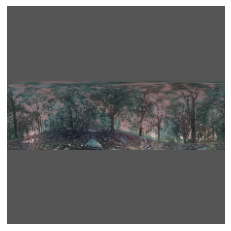

tensor([[[[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/its/home/nn268/antvis/optics/AugmentedDS_IDSW/IDSW003_100323_1515_W.JPG_Augmented_right_1.JPG
processed x 
  torch.Size([1, 3, 224, 224])


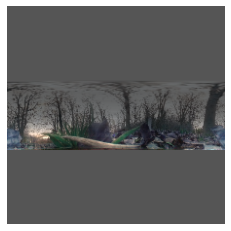

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0

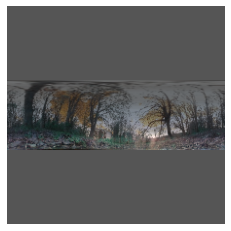

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0

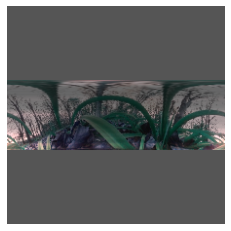

tensor([[[[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


processed x 
  torch.Size([1, 3, 224, 224])


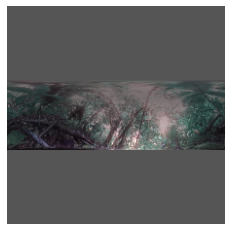

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0

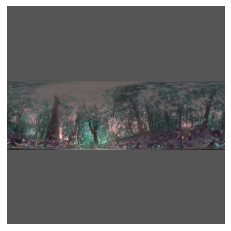

tensor([[[[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0

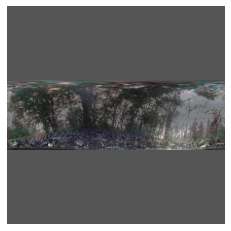

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0

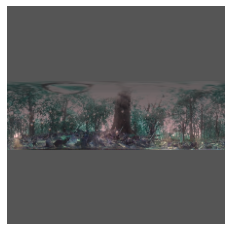

tensor([[[[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0

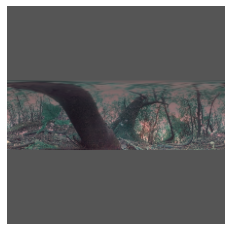

tensor([[[[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0

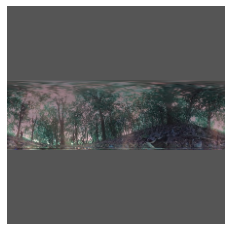

 33%|███▎      | 1/3 [00:06<00:13,  6.82s/it]

tensor([[[[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0

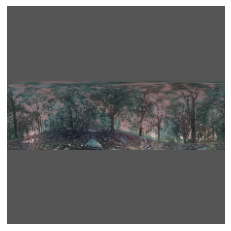

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0

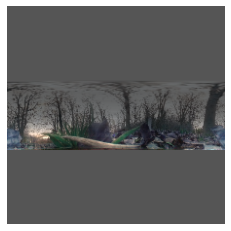

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0

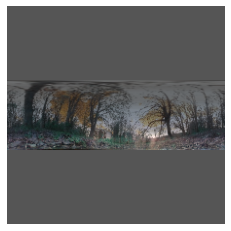

tensor([[[[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


processed x 
  torch.Size([1, 3, 224, 224])


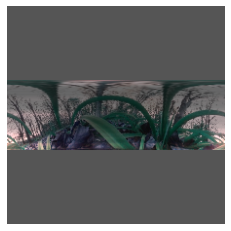

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0

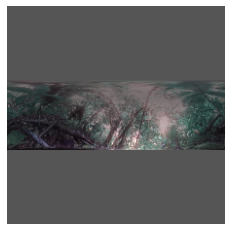

tensor([[[[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


val preprocessed x 
  torch.Size([1, 3, 224, 224])


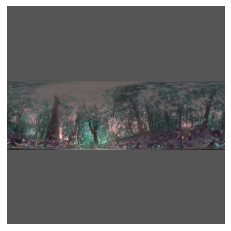

tensor([[[[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0

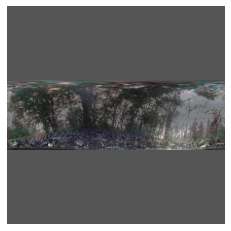

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0

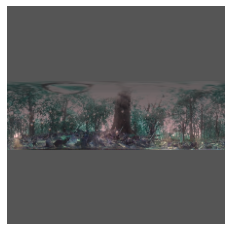

tensor([[[[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0

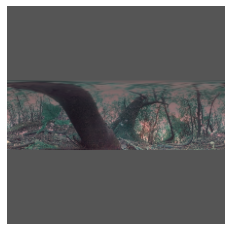

tensor([[[[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0

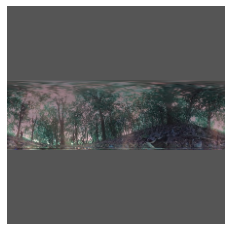

 67%|██████▋   | 2/3 [00:08<00:03,  3.92s/it]

tensor([[[[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0

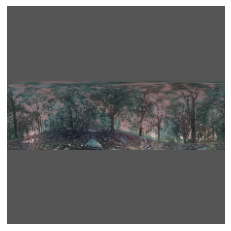

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0

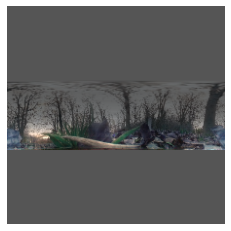

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0

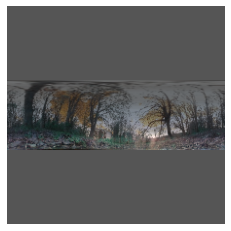

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0

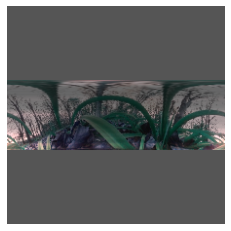

tensor([[[[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


processed x 
  torch.Size([1, 3, 224, 224])


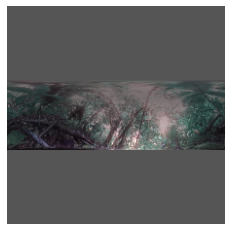

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0

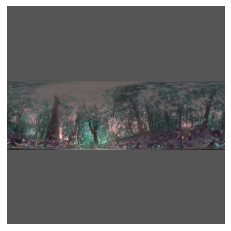

tensor([[[[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0

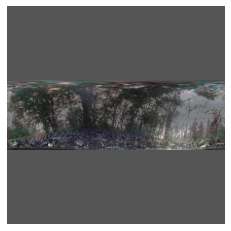

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0

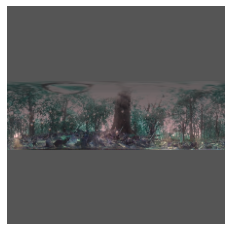

tensor([[[[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0

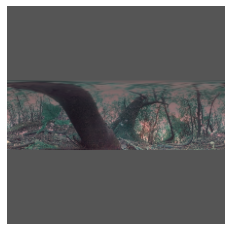

tensor([[[[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0

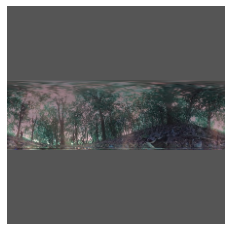

100%|██████████| 3/3 [00:10<00:00,  3.67s/it]

tensor([[[[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          ...,
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668]],

         [[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0

'def tr(config=None):\n    with wandb.init(config=config):\n        config = wandb.config\n        model, save_dict = pipeline(config)\n        \n\nwandb.agent(sweep_id, tr, count=20)'

In [13]:
model,save_dict = pipeline(config) #7,168

"""def tr(config=None):
    with wandb.init(config=config):
        config = wandb.config
        model, save_dict = pipeline(config)
        

wandb.agent(sweep_id, tr, count=20)"""

In [14]:
!nvidia-smi

Tue Nov 28 10:09:45 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A6000               Off | 00000000:01:00.0 Off |                  Off |
| 37%   67C    P2             227W / 300W |  22045MiB / 49140MiB |     61%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [15]:
# confusion matrix


def plot_confusion(predictions:list, actual:list, title:str):
    predict_list = [int(t.argmax()) for t in predictions]
    actual = [int(l.argmax()) for l in actual]

    actual = np.array(actual)
    predict_list = np.array(predict_list)


    #FixedLocator locations (3), usually from a call to set_ticks, does not match the number of labels (11).
    print(f'\n     {title}')
    train_epoch_matrix = confusion_matrix(actual, predict_list, labels= [0,1,2,3,4,5,6,7,8,9,10])
    disp= ConfusionMatrixDisplay(train_epoch_matrix, display_labels=[0,1,2,3,4,5,6,7,8,9,10])
    disp.plot()
    plt.show()


In [16]:
t_predict = save_dict['t_predict_list']
t_labels = save_dict['t_labels']

v_predict = save_dict['v_predict_list'] # WHY IS THERE NOTHING IN V OREDICT LIST!
v_labels = save_dict['v_labels']

plot_confusion(t_predict, t_labels, 'Train Confusion Matrix')
plot_confusion(v_predict, v_labels, 'Validation Confusion Matrix')

KeyError: 't_predict_list'

In [ ]:
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
    
    def forward(self, x):
        # Do your print / debug stuff here
        print(x)
        return x

In [ ]:
model =nn.Sequential(
    PrintLayer(),
    model_vgg16,
    PrintLayer(),
    Squeeze(),
    PrintLayer(),
    nn.Linear(4096,11),
    PrintLayer(),
    nn.Softmax(dim=0),
    PrintLayer()

).to(device)

In [ ]:

vgg = nn.Sequential(
        model_vgg16,
        Squeeze(),
        nn.Linear(4096,11),
        nn.Softmax(dim=0),
    )

#model_vgg16.to('cpu')

vgg.to(device)
next(vgg.parameters()).is_cuda

In [ ]:

x = preprocess_im(x_train[0])


train_prediction = model.forward(x)

In [ ]:
model.to('cpu').state_dict()